## Libraries

In [40]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
lst_files = os.listdir("../input")
lst_files = [os.path.join('../input', x) for x in lst_files]
lst_files

['../input/sales_train.csv.gz',
 '../input/test.csv.gz',
 '../input/items.csv',
 '../input/sample_submission.csv.gz',
 '../input/shops.csv',
 '../input/item_categories.csv']

### Loading data

In [67]:
# Reading in all datasets
train = pd.read_csv(lst_files[0])
test = pd.read_csv(lst_files[1])
items = pd.read_csv(lst_files[2])
sample_sub = pd.read_csv(lst_files[3])
shops = pd.read_csv(lst_files[4])
cat = pd.read_csv(lst_files[5])

In [68]:
# Merge all datasets into full_train
full_train = train.merge(items, on='item_id')
full_train = full_train.merge(cat, on='item_category_id')
full_train = full_train.merge(shops, on='shop_id')

In [ ]:
full_train.head()

## EDA

In [69]:
full_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [70]:
# Remove negative pricing
full_train1 = full_train[~(full_train['item_price'] < 0)]

In [71]:
# Remove negative no. of product sold in a day
full_train1 = full_train1[~(full_train1['item_cnt_day'] < 0)]

**Trying to figure out if negative no. of products sold is normal and should be kept.   
Could not really tell after plotting out the `item_cnt_day` values for negative and full.  
Will remove them until further evidence surfaces**

In [73]:
full_train[full_train['item_cnt_day'] < 0].groupby('date_block_num').count()

,date,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
date_block_num,,,,,,,,,
0,352,352,352,352,352,352,352,352,352
1,287,287,287,287,287,287,287,287,287
2,294,294,294,294,294,294,294,294,294
3,244,244,244,244,244,244,244,244,244
4,177,177,177,177,177,177,177,177,177
5,201,201,201,201,201,201,201,201,201
6,198,198,198,198,198,198,198,198,198
7,277,277,277,277,277,277,277,277,277
8,219,219,219,219,219,219,219,219,219


In [54]:
x_axis = full_train[full_train['item_cnt_day'] < 0].groupby('date_block_num').count().index

In [55]:
y_axis = full_train[full_train['item_cnt_day'] < 0].groupby('date_block_num').count()['item_cnt_day'].values

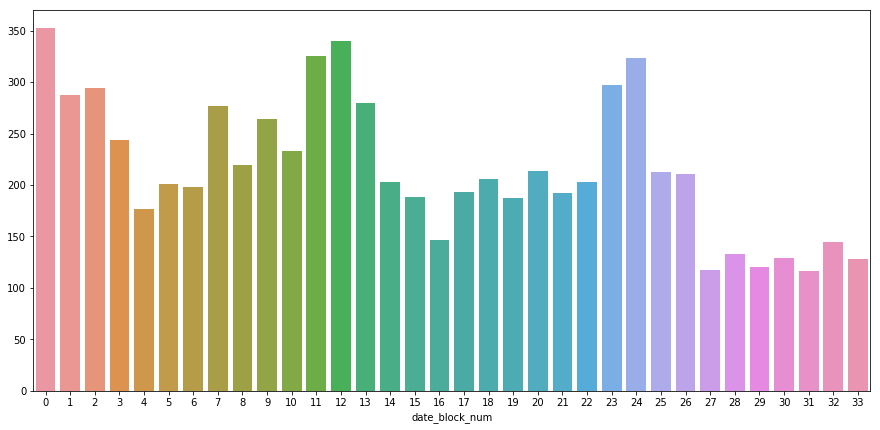

In [56]:
sns.barplot(x_axis, y_axis)
plt.rcParams['figure.figsize'] = [15, 7]
plt.show()

In [23]:
full_train.groupby('date_block_num').count()

,date,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
date_block_num,,,,,,,,,
0,115690,115690,115690,115690,115690,115690,115690,115690,115690
1,108613,108613,108613,108613,108613,108613,108613,108613,108613
2,121347,121347,121347,121347,121347,121347,121347,121347,121347
3,94109,94109,94109,94109,94109,94109,94109,94109,94109
4,91758,91758,91758,91758,91758,91758,91758,91758,91758
5,100403,100403,100403,100403,100403,100403,100403,100403,100403
6,100548,100548,100548,100548,100548,100548,100548,100548,100548
7,104772,104772,104772,104772,104772,104772,104772,104772,104772
8,96137,96137,96137,96137,96137,96137,96137,96137,96137


In [57]:
x_axis1 = full_train.groupby('date_block_num').count().index

In [58]:
y_axis1 = full_train.groupby('date_block_num').count()['item_cnt_day'].values

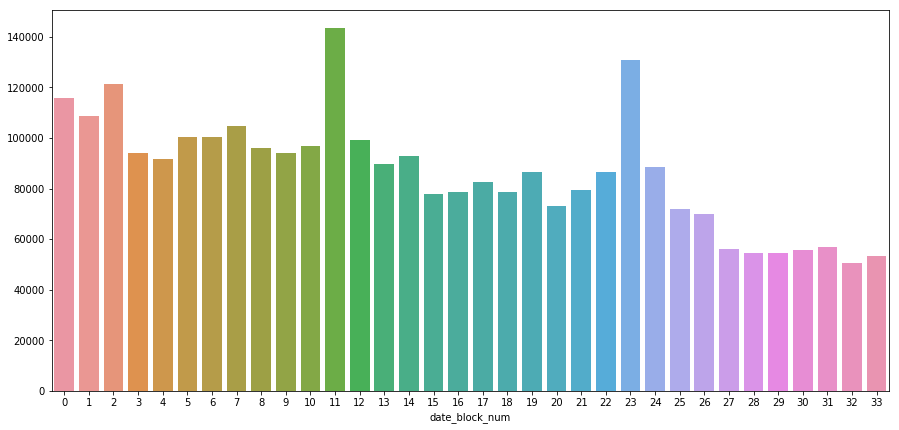

In [59]:
sns.barplot(x_axis1, y_axis1)
plt.rcParams['figure.figsize'] = [15, 7]
plt.show()

**Sales in 11 (December 2013) and 23 (December 2014) is the highest
What happened in 2015 that led to huge fall in sales?**

** Checking for correlation between independent variables**

In [62]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


In [87]:
columns = ['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_cnt_day']

In [99]:
correlation_matrix = pd.DataFrame(index=columns,
                                  columns=columns)

In [100]:
correlation_matrix

,date_block_num,shop_id,item_id,item_category_id,item_cnt_day
date_block_num,NaN,NaN,NaN,NaN,NaN
shop_id,NaN,NaN,NaN,NaN,NaN
item_id,NaN,NaN,NaN,NaN,NaN
item_category_id,NaN,NaN,NaN,NaN,NaN
item_cnt_day,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i in correlation_matrix.index:
    for j in correlation_matrix:
        x = full_train[j]
        y = full_train[i]
        
        if x.name == y.name:
            correlation_matrix[i][j] = 1.0
        else: 
#             print(x.name, y.name)
            v = cramers_v(x,y)
            correlation_matrix[i][j] = v

In [107]:
correlation_matrix

,date_block_num,shop_id,item_id,item_category_id,item_cnt_day
date_block_num,1,0.0826512,0.301734,0.0756157,0.0132518
shop_id,0.0826512,1,0.174125,0.150569,0.0191566
item_id,0.301734,0.174125,1,0.996293,0.0383888
item_category_id,0.0756157,0.150569,0.996293,1,0.053945
item_cnt_day,0.0132518,0.0191566,0.0383888,0.053945,1


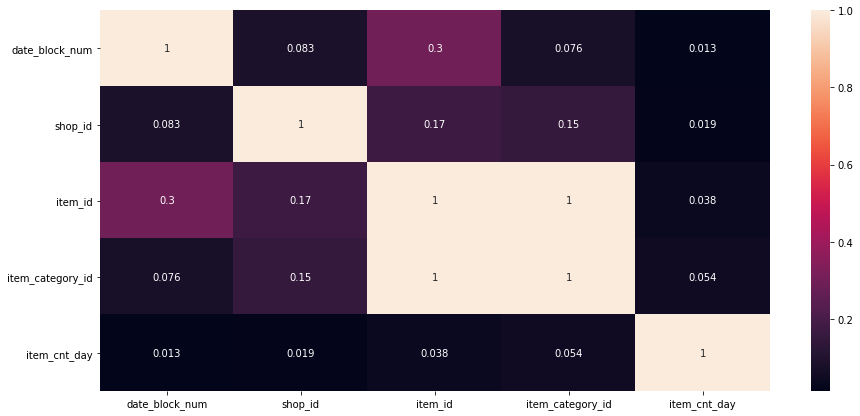

In [111]:
correlation_matrix.fillna(value=np.nan, inplace=True)
plt.figure(figsize=(15,7))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

** Check for outliers **
* TODO decide if we should remove outliers

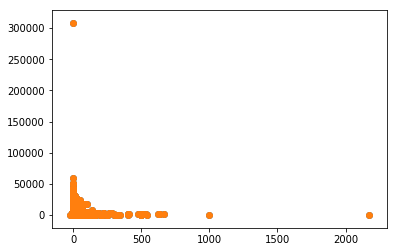

In [12]:
plt.scatter(full_train['item_cnt_day'], full_train['item_price'])
plt.show()

** Outlier on item_cnt_day >>>> 1000 and item_price >>>>100,000  
Check these records and see if we should remove them **


In [13]:
full_train[full_train['item_cnt_day'] > 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
2694327,28.10.2015,33,12,11373,0.908714,2169.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС


In [14]:
full_train[full_train['item_id'] == 11373].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,464.000000,464.0,464.0,464.000000,464.000000,464.0
mean,19.948276,12.0,11373.0,367.548909,14.144397,9.0
std,8.817658,0.0,0.0,296.953061,104.604937,0.0
min,0.000000,12.0,11373.0,0.908714,1.000000,9.0
25%,13.000000,12.0,11373.0,184.616848,2.000000,9.0
50%,21.000000,12.0,11373.0,281.625000,4.000000,9.0
75%,28.000000,12.0,11373.0,443.083333,8.000000,9.0
max,33.000000,12.0,11373.0,2137.000000,2169.000000,9.0


In [13]:
full_train[full_train['item_id'] == 11373].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
2693870,08.01.2013,0,12,11373,1000.0,1.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2693871,31.01.2013,0,12,11373,97.8,5.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2693872,01.02.2013,1,12,11373,229.0,1.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2693873,04.02.2013,1,12,11373,130.0,1.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
2693874,29.03.2013,2,12,11373,139.5,2.0,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС


Item is a delivery service which only shop_id 12 has. Could remove this outlier to ensure better scaling.

** Check if all item_id to item_price is unique **

In [41]:
full_train[['shop_id','item_id', 'item_price']].groupby('item_id').get_group(3)

,shop_id,item_id,item_price
915726,54,3,100.0
915727,54,3,58.0


In [44]:
full_train[['shop_id', 'item_id','item_price']].groupby('item_id').get_group(22141)

,shop_id,item_id,item_price
29177,59,22141,399.0
29178,59,22141,399.0
307923,25,22141,399.0
307924,25,22141,399.0
307925,25,22141,399.0
307926,25,22141,399.0
307927,25,22141,399.0
307928,25,22141,399.0
307929,25,22141,399.0
440974,6,22141,399.0


** Nope, an item at same shop could be sold at different price, item is not unique to a shop**

** Check for duplicated shop names with different id **

In [7]:
shops.sort_values(by='shop_name')

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


** Create new feature: city**

## Preprocessing

In [74]:
train = full_train1.groupby(['date_block_num',
              'shop_id',
              'item_id']).agg({'item_cnt_day': ['sum']})

In [75]:
train.columns = ['item_cnt_month']

In [76]:
train = train.reset_index()

In [77]:
train.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [78]:
train.item_cnt_month.value_counts()

1.0       1060054
2.0        266172
3.0        103481
4.0         53491
5.0         32037
6.0         20804
7.0         14087
8.0         10464
9.0          7546
10.0         6045
11.0         4486
12.0         3711
13.0         3066
14.0         2457
15.0         2075
16.0         1751
17.0         1576
18.0         1305
19.0         1106
20.0         1037
21.0          827
22.0          728
23.0          665
24.0          545
25.0          518
26.0          480
27.0          425
28.0          412
29.0          367
30.0          335
           ...   
142.0           1
941.0           1
430.0           1
431.0           1
904.0           1
903.0           1
899.0           1
1066.0          1
404.0           1
1074.0          1
374.0           1
365.0           1
369.0           1
370.0           1
272.0           1
1242.0          1
371.0           1
373.0           1
1209.0          1
375.0           1
401.0           1
432.0           1
378.0           1
380.0           1
1127.0    

In [47]:
# Labels
y = train.item_cnt_month.values

In [49]:
train = train.drop(['date_block_num', 'item_cnt_month'], axis=1)
x = train.values

In [79]:
# Create training and validation sets
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Models

### LightGBM

In [88]:
# Create LightGBM data containers
train_data = lgb.Dataset(x, label=y, categorical_feature=[0,1])

AttributeError: 'Dataset' object has no attribute 'head'

### Linear Regression
- one-hot encoding with categorical id

In [25]:
x = full_train[['shop_id','item_id']]

In [30]:
x.reset_index(inplace=True)

In [32]:
x = x.rename(columns={'index':'ID'})

In [33]:
y = full_train['item_cnt_day']

In [34]:
x = pd.get_dummies(data=x, drop_first=True)

In [35]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
lr.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [37]:
test = pd.get_dummies(data=test, drop_first=True)

In [38]:
score = lr.predict(test)

In [39]:
score

array([ 1.21754413,  1.21952824,  1.2189183 , ...,  1.25723734,
        1.28451701,  1.15355923])